In [2]:
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
use_amp = True
batch_size = 30
image_channels = 3
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
trans = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize((128, 128),  antialias=True)
])

In [5]:
train = tv.datasets.CIFAR10('./Datasets/', download=True, transform=trans, train=True)
test = tv.datasets.CIFAR10('./Datasets/', download=True, transform=trans, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
labels = torch.zeros(len(train.classes), dtype=torch.long)

for _, target in train:
    labels[target-1]+=1

print(labels)

tensor([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])


In [7]:
len(labels)

10

In [8]:
train[1000][0].shape

torch.Size([3, 128, 128])

horse


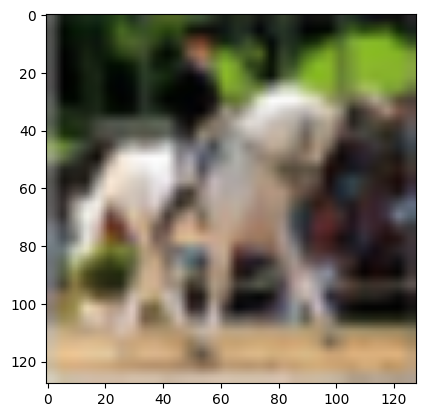

In [9]:
plt.imshow(train[1200][0].permute(1, 2, 0))
print(train.classes[train[1200][1]])

In [10]:
train_dataloader = torch.utils.data.DataLoader(train,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=1,
                                         drop_last=True)

In [11]:
for i, j in train_dataloader:
    print(i.shape)
    print(j.shape)
    break

torch.Size([30, 3, 128, 128])
torch.Size([30])


In [12]:
def padding_calc(input_matrix_shape: tuple, out_matrix_shape: tuple, kernel_size:tuple, stride:int) -> tuple:

    padding_h = (stride * (out_matrix_shape[0] - 1) - input_matrix_shape[0] +
                 kernel_size[0]) / 2
    padding_w = (stride * (out_matrix_shape[1] - 1) - input_matrix_shape[1] +
                 kernel_size[1]) / 2

    return padding_h, padding_w

In [13]:
def output_shape_calc(input_matrix_shape: tuple, padding: int,
                      kernel_size: tuple, stride: int) -> tuple:
    h = (2 * padding[0] - kernel_size[0] + input_matrix_shape[0]) / stride + 1
    w = (2 * padding[1] - kernel_size[1] + input_matrix_shape[1]) / stride + 1

    return h, w

In [14]:
class ResBlock(torch.nn.Module):
    def __init__(self, num_ch: int):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)
        
        self.conv0 = torch.nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1)
        self.norm0 = torch.nn.BatchNorm2d(num_ch)

        self.conv1 = torch.nn.Conv2d(num_ch, num_ch, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(num_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        return out + x


In [15]:
class ResBottleneckBlock(torch.nn.Module):
    def __init__(self, num_ch: int):
        super().__init__()
        self.act = torch.nn.LeakyReLU(0.2)

        self.conv0 = torch.nn.Conv2d(num_ch, num_ch//4, kernel_size=1, padding=0)
        self.norm0 = torch.nn.BatchNorm2d(num_ch//4)

        self.conv1 = torch.nn.Conv2d(num_ch//4, num_ch//4, kernel_size=3, padding=1)
        self.norm1 = torch.nn.BatchNorm2d(num_ch//4)

        self.conv2 = torch.nn.Conv2d(num_ch//4, num_ch, kernel_size=1, padding=0)
        self.norm2 = torch.nn.BatchNorm2d(num_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.norm0(out)
        out = self.act(out)
        out = self.conv1(out)
        out = self.norm1(out)
        out = self.act(out)
        out = self.conv2(out)
        out = self.norm2(out)

        return x + out


In [16]:
class ResStackBlock(torch.nn.Module):
    def __init__(self, num_blocks: int, num_ch: int, block_type="classic"):
        super().__init__()
        stack = []

        for i in range(num_blocks):
            if block_type == "classic":
                stack.append(ResBlock(num_ch))
            elif block_type == "bottleneck":
                stack.append(ResBottleneckBlock(num_ch))
            else:
                raise NotImplementedError(f'{block_type} is not implemented')

        self.stack = torch.nn.Sequential(*stack)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.stack(x)


In [17]:
class MyResNet(torch.nn.Module):
    def __init__(self, input_ch: int, num_classes: int, num_ch: int, block_type="classic"):
        super().__init__()

        self.conv0 = torch.nn.Conv2d(input_ch, num_ch, kernel_size=7, stride=2)
        self.act = torch.nn.LeakyReLU(0.2)
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 =  ResStackBlock(num_blocks=3, num_ch=num_ch, block_type=block_type)
        self.conv1_1 = torch.nn.Conv2d(in_channels=num_ch, out_channels=2*num_ch, kernel_size=3, padding=1, stride=2)
        self.conv1_2 = torch.nn.Conv2d(in_channels=2*num_ch, out_channels=2*num_ch, kernel_size=3, padding=1)
        self.layer2 =  ResStackBlock(num_blocks=3, num_ch=2*num_ch, block_type=block_type)
        self.conv2_1 = torch.nn.Conv2d(in_channels=2*num_ch, out_channels=4*num_ch, kernel_size=3, padding=1, stride=2)
        self.conv2_2 = torch.nn.Conv2d(in_channels=4*num_ch, out_channels=4*num_ch, kernel_size=3, padding=1)
        self.layer3 =  ResStackBlock(num_blocks=5, num_ch=4*num_ch, block_type=block_type)
        self.conv3_1 = torch.nn.Conv2d(in_channels=4*num_ch, out_channels=8*num_ch, kernel_size=3, padding=1, stride=2)
        self.conv3_2 = torch.nn.Conv2d(in_channels=8*num_ch, out_channels=8*num_ch, kernel_size=3, padding=1)
        self.layer4 =  ResStackBlock(num_blocks=2, num_ch=8*num_ch, block_type=block_type)

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1,1))
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(8*num_ch, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv0(x)
        out = self.act(out)
        out = self.max_pool(out)

        out = self.layer1(out)
        out = self.conv1_1(out)
        out = self.conv1_2(out)

        out = self.layer2(out)
        out = self.conv2_1(out)
        out = self.conv2_2(out)

        out = self.layer3(out)
        out = self.conv3_1(out)
        out = self.conv3_2(out)

        out = self.layer4(out)
        out = self.avgpool(out)
        out = self.flatten(out)
        out = self.linear(out)

        return out


In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
model = MyResNet(image_channels, len(train.classes), 32, block_type="bottleneck")
model = model.to(device)

In [20]:
count_parameters(model)

1418522

In [21]:
loss_fn = torch.nn.CrossEntropyLoss()
loss = loss_fn.to(device)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

In [23]:
scaler = torch.cuda.amp.GradScaler()

In [24]:
def accuracy(pred, label):
  answer = pred.detach().numpy().argmax(1) == label.numpy()
  return answer.mean()

In [25]:
epochs = 3

accuracy_history = []

for epoch in range(epochs):
    for img, label in (pbar := tqdm(train_dataloader)):
        optimizer.zero_grad()

        img = img.to(device)
        label = label.to(device)

        with autocast(use_amp):
            pred = model(img)
            loss = loss_fn(pred, label)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        acc_current = accuracy(pred.cpu(), label.cpu())
        pbar.set_description(f'accuracy: {acc_current:.3f}')

    test_pred = model(torch.tensor(test.data).permute(0, 3, 1, 2).float().to(device))
    accuracy_history.append(accuracy(test_pred.cpu(), torch.tensor(test.targets)))

accuracy: 0.800: 100%|██████████| 1666/1666 [00:52<00:00, 31.59it/s]


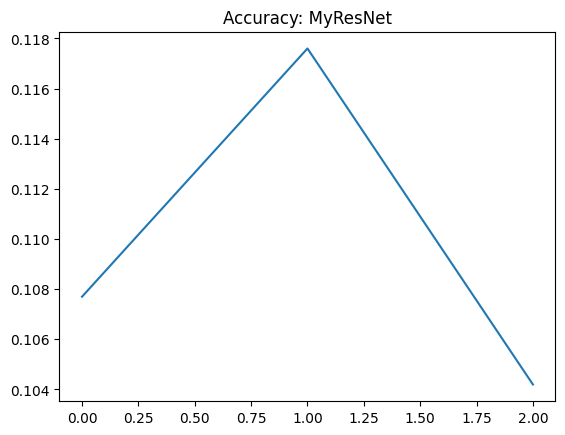

In [26]:
plt.title('Accuracy: MyResNet')
plt.plot(accuracy_history)

In [27]:
label.cpu()

tensor([3, 5, 2, 3, 6, 6, 1, 5, 9, 2, 5, 8, 3, 0, 8, 7, 7, 2, 3, 5, 1, 0, 1, 3,
        4, 2, 7, 8, 9, 1])

In [28]:
pred.detach().cpu().argmax(1)

tensor([3, 5, 2, 2, 6, 6, 1, 5, 9, 2, 2, 8, 4, 0, 8, 7, 7, 2, 5, 5, 1, 0, 1, 3,
        4, 2, 2, 9, 9, 1])

In [29]:
torch.tensor(test.targets)[0:10]

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])

In [30]:
model(torch.tensor(test.data).permute(0, 3, 1, 2).float().to(device)).detach().cpu().argmax(1)[0:10]

tensor([3, 9, 9, 9, 1, 3, 3, 1, 9, 9])